In [1]:
#Import packages
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal

# 1 Exploring the Data

## Loading the Data

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Size of Images: 8x8 = 64 pixels

In [3]:
#Use numpy shape function of exemplary entry
images[0].shape

(8, 8)

Plot exemplary image of a three

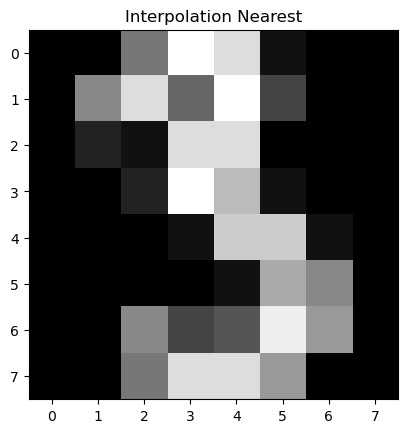

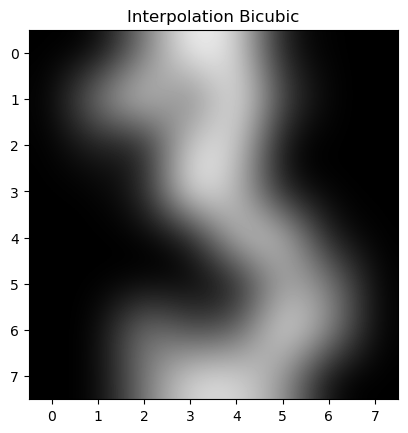

In [4]:
#Luckily the data set is already put in ascending order starting anew with every decade
img = images[3]

#Check if image is a 2x2 array
assert 2 == len(img.shape)

#Plot images with two different interpolations
plt.figure(1)
plt.gray()
plt.title('Interpolation Nearest')
plt.imshow(img, interpolation = 'nearest')

plt.figure(2)
plt.title('Interpolation Bicubic')
plt.gray()
plt.imshow(img, interpolation = 'bicubic')

Filter data with threes and nines

In [5]:
images_fil = images[(target == 3) | (target == 9)]
data_fil = data[(target == 3) | (target == 9)]
target_fil = target[(target == 3) | (target == 9)]
target_names_fil = target_names[(target_names == 3) | (target_names == 9)]

In [6]:
from sklearn import model_selection

X_all = data_fil
y_all = target_fil


X_train, X_test, y_train, y_test = model_selection.train_test_split(data_fil, target_fil, test_size = 0.4, random_state = 0)


# 2 Hand-crafted classifier

## 2.1 Feature construction

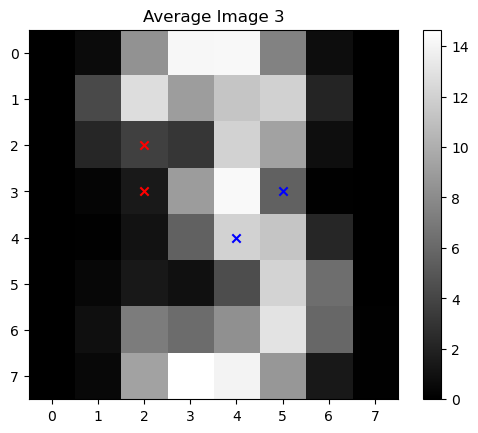

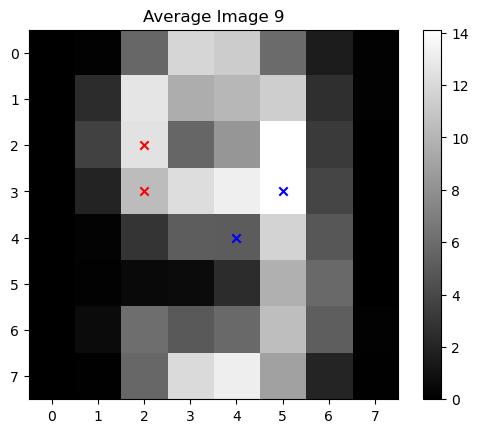

In [7]:
#First plot average images for 3 and 9 and find pixels which distinguish the most from each other in both images
img_3 = images_fil[target_fil == 3]
img_3 = img_3.mean(axis = 0)

plt.figure()
#plt.gray()
plt.title('Average Image 3')
cmesh = plt.imshow(img_3, interpolation = 'nearest')
plt.scatter(2, 2, color = 'r', marker = 'x')
plt.scatter(2, 3, color = 'r', marker = 'x')
plt.scatter(5, 3, color = 'b', marker = 'x')
plt.scatter(4, 4, color = 'b', marker = 'x')
plt.colorbar(cmesh)

img_9 = images_fil[target_fil == 9]
img_9 = img_9.mean(axis = 0)

data_9 = data_fil[target_fil == 9]
data_9 = data_9.mean(axis = 0)

plt.figure()
#plt.gray()
plt.title('Average Image 9')
cmesh = plt.imshow(img_9, interpolation = 'nearest')
plt.scatter(2, 2, color = 'r', marker = 'x')
plt.scatter(2, 3, color = 'r', marker = 'x')
plt.scatter(5, 3, color = 'b', marker = 'x')
plt.scatter(4, 4, color = 'b', marker = 'x')
plt.colorbar(cmesh)

In [8]:
#Define function for chosen features
def features2d(x):
    pixel_1 = (3, 5)
    pixel_2 = (2, 2)
    pixel_3 = (4, 4)
    pixel_4 = (3, 2)
    
    #Create new array with shape (#instances x 2)
    new_array = np.zeros((x.shape[0], 2))
    
    #Get data of chosen pixels
    feature_1 = x[:, pixel_1[0]*8+pixel_1[1]] - x[:, pixel_3[0]*8+pixel_3[1]]
    feature_2 = x[:, pixel_2[0]*8+pixel_2[1]] + x[:, pixel_4[0]*8+pixel_4[1]]
    
    #Write values into new array
    new_array[:, 0] = feature_1
    new_array[:, 1] = feature_2
    
    return new_array

## 2.2 Scatterplot

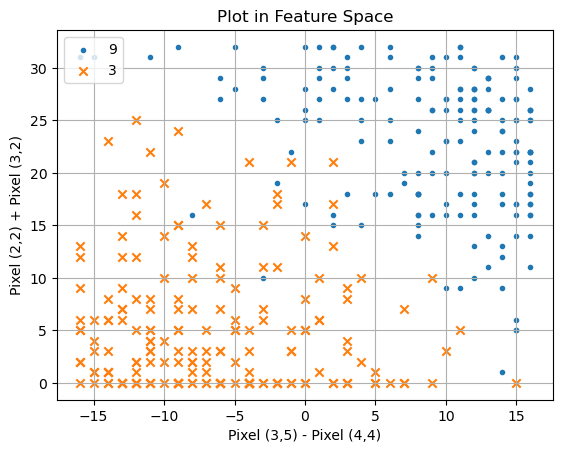

In [9]:
features = features2d(data_fil)
fea_9 = features[target_fil == 9]
fea_3 = features[target_fil == 3]

plt.figure()
plt.grid()
plt.title('Plot in Feature Space')
plt.xlabel('Pixel (3,5) - Pixel (4,4)')
plt.ylabel('Pixel (2,2) + Pixel (3,2)')
plt.scatter(fea_9[:, 0], fea_9[:, 1], marker = ".", label = '9')
plt.scatter(fea_3[:, 0], fea_3[:, 1], marker = "x", label = '3')
plt.legend()


## 2.3 Decision Rule

In [10]:
# Define function nearest_mean for decision rule as described in exercise sheet
def nearest_mean(training_features, training_labels, test_features):
    
    fea_9_train = training_features[training_labels == 9]
    fea_3_train = training_features[training_labels == 3]

    fea_9_train_m = fea_9_train.mean(axis = 0)
    fea_3_train_m = fea_3_train.mean(axis = 0)
    
    diff_3 = test_features - fea_3_train_m
    dist_3 = np.sqrt(diff_3[:,0]**2 + diff_3[:,1]**2)
    diff_9 = test_features - fea_9_train_m
    dist_9 = np.sqrt(diff_9[:,0]**2 + diff_9[:,1]**2)
    
    return np.where(dist_3 < dist_9, 3, 9), fea_3_train_m, fea_9_train_m

In [11]:
# Use upper function to assign labels to test data (and training data again)
features_train = features2d(X_train)
features_test = features2d(X_test)

labels_train, mean_3_tr, mean_9_tr = nearest_mean(features_train, y_train, features_train)
labels_test, mean_3_tr, mean_9_tr = nearest_mean(features_train, y_train, features_test)

# Calculate training and test error
error_train_rate = np.sum(y_train != labels_train)/len(y_train)*100
error_test_rate = np.sum(y_test != labels_test)/len(y_test)*100

print('The error rates for training and test data sets are {:.2f} % and {:.2f} %, respectively\n'.format(error_train_rate, error_test_rate))
print('This leads to precision rates of {:.2f} % and {:.2f} %, respectively\n'.format(100-error_train_rate, 100-error_test_rate))


The error rates for training and test data sets are 3.23 % and 3.42 %, respectively

This leads to precision rates of 96.77 % and 96.58 %, respectively



## 2.4 Visualize the decision regions

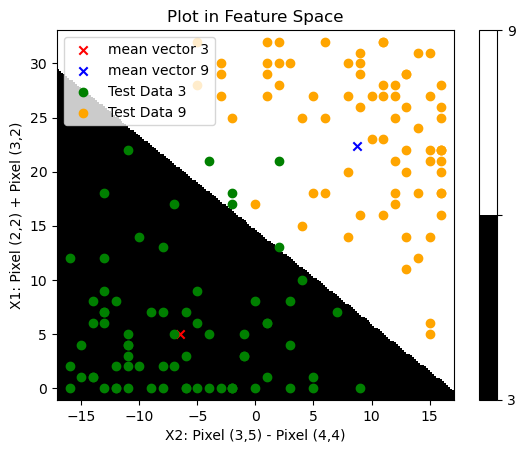

In [12]:
#Create meshgrid for the colorshading plot
X_1 = np.linspace(-17, 17, 200)
X_2 = np.linspace(-1, 33, 200)
X_1, X_2 = np.meshgrid(X_1, X_2)
features_grid = np.array([X_1.flatten(),X_2.flatten()]).T

#Carry out nearest_mean function for training data set from above
labels_grid, mean_3_tr, mean_9_tr = nearest_mean(features_train, y_train, features_grid)
labels_grid = labels_grid.reshape(200, 200)
plt.figure()

bounds = [3, 9, 10]

plt.title('Plot in Feature Space')
plt.xlabel('X2: Pixel (3,5) - Pixel (4,4)')
plt.ylabel('X1: Pixel (2,2) + Pixel (3,2)')
cmap = plt.cm.summer
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmesh = plt.pcolormesh(X_1, X_2, labels_grid, norm = norm, cmap = plt.cm.gray)
cbar = plt.colorbar(cmesh)
cbar.ax.set_yticklabels(['3','','9'])

#Add also scatter plots
#Two class means
plt.scatter(mean_3_tr[0], mean_3_tr[1], marker = "x", label = "mean vector 3", color = 'r')
plt.scatter(mean_9_tr[0], mean_9_tr[1], marker = "x", label = "mean vector 9", color = 'b')

#Add test data
features_test_3 = features_test[y_test == 3]
features_test_9 = features_test[y_test == 9]
plt.scatter(features_test_3[:, 0], features_test_3[:, 1], color = 'green', label = 'Test Data 3')
plt.scatter(features_test_9[:, 0], features_test_9[:, 1], color = 'orange', label = 'Test Data 9')

#Add legend
plt.legend()

# 3 LDA

## 3.1 Implement LDA training

In [36]:
def fit_lda(training_data, training_labels):
    
    #Throw out pixels with variance smaller than 0.001 (dead pixels)
    var = np.repeat(training_data.var(axis = 0)[np.newaxis, :], len(training_data), axis=0)
    training_data = np.where(var > 0.001, training_data, np.nan)
    
    if training_data.shape[1] != 2:
        training_features = features2d(training_data)
    else: 
        training_features = training_data
        
    #Split data according to classes
    train_feat_3 = training_features[training_labels == -1]
    train_feat_9 = training_features[training_labels == 1]
    
    #Compute mean of both classes
    train_mean_3 = train_feat_3.mean(axis = 0)
    train_mean_9 = train_feat_9.mean(axis = 0)
    mu = np.array([train_mean_3, train_mean_9])
    
    
    #Compute standard deviation
    covmat = 1/len(training_features) * (np.matmul((train_feat_3-train_mean_3).T, train_feat_3-train_mean_3) + 
                                         np.matmul((train_feat_9-train_mean_9).T, train_feat_9-train_mean_9))
        
    #Compute priors
    prior_3 = len(train_feat_3)/len(training_features)
    prior_9 = len(train_feat_9)/len(training_features)
    
    return mu, covmat, np.array([prior_3, prior_9])
    

In [23]:
features_train.shape

(217, 2)

In [37]:
#Turn labels into +/-1 classifiers
training_labels = np.where(y_train == 3, -1, 1)
test_labels = np.where(y_test == 3, -1, 1)
#Compute mean and covariance matrix with upper function - Set to X_train if unseen data was to use
mean, covmat, p = fit_lda(features_train, training_labels)

(2, 111)
[-7.54054054 -3.95495495]
(111, 2)
(2, 2)


In [15]:
def gaus(x, mu, covmat):
    return 1/np.sqrt(np.linalg.det(2*np.pi*covmat))*np.exp(-0.5*np.matmul(np.matmul((x-mu), np.linalg.inv(covmat)), (x-mu).T))

#Implement LDA prediction
def predict_lda(mu, covmat, p, test_data):
    
    if test_data.shape[1] != 2:
        test_features = features2d(test_data)
    else:
        test_features = test_data 
    
    #Use linear classifier of LDA from lecture
    beta = np.linalg.inv(covmat) @ (mu[1] - mu[0]).T
    b = -0.5*(mu[0] + mu[1]) @ beta + np.log(p[1]/p[0])
    predicted_labels = np.sign(test_features @ beta + b) 
    
    return predicted_labels

In [16]:
# Compute predicted labels - Set to X_test if unseen data was to use
predicted_labels_LDA = predict_lda(mean, covmat, p, X_test)

## 3.2 Visualization

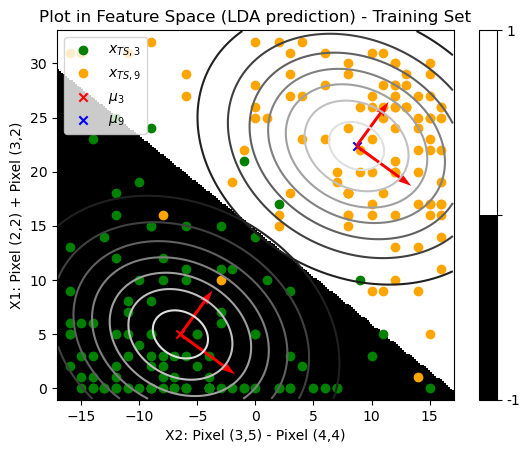

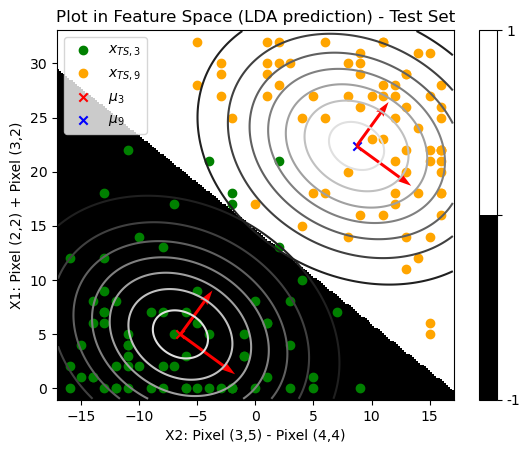

In [17]:
#Create meshgrid for the colorshading plot
X_1 = np.linspace(-17, 17, 200)
X_2 = np.linspace(-1, 33, 200)
X_1, X_2 = np.meshgrid(X_1, X_2)
features_grid = np.array([X_1.flatten(),X_2.flatten()]).T

#Carry out nearest_mean function for training data set from above
labels_grid_LDA = predict_lda(mean, covmat, p, features_grid)
labels_grid_LDA = labels_grid_LDA.reshape(200, 200)
fig_TrS = plt.figure()

bounds = [3, 9, 10]

plt.title('Plot in Feature Space (LDA prediction) - Training Set')
plt.xlabel('X2: Pixel (3,5) - Pixel (4,4)')
plt.ylabel('X1: Pixel (2,2) + Pixel (3,2)')

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmesh = plt.pcolormesh(X_1, X_2, labels_grid, norm = norm, cmap = plt.cm.gray)
cbar = plt.colorbar(cmesh)
cbar.ax.set_yticklabels(['-1','','1'])

#Add scatter plot of training data
features_train_3 = features_train[training_labels == -1]
features_train_9 = features_train[training_labels == 1]
plt.scatter(features_train_3[:, 0], features_train_3[:, 1], color = 'green', label = '$x_{TS, 3}$')
plt.scatter(features_train_9[:, 0], features_train_9[:, 1], color = 'orange', label = '$x_{TS, 9}$')

plt.scatter(mean[0][0], mean[0][1], marker = "x", label = "$\mu_3$", color = 'r')
plt.scatter(mean[1][0], mean[1][1], marker = "x", label = "$\mu_9$", color = 'b')
plt.legend()

#Plot ellipses from scipy function (not according to standard deviations)
pos = np.dstack((X_1, X_2))
ellipse_3 = multivariate_normal(mean[0, :], covmat, [2.0, 10.0])
ellipse_9 = multivariate_normal(mean[1, :], covmat, [2.0, 10.0])

plt.contour(X_1, X_2, ellipse_3.pdf(pos))
plt.contour(X_1, X_2, ellipse_9.pdf(pos))

#Carry out eigenvalue decomposition of covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(covmat)

#Vectors of eigen axes (scales with one sigma in each direction- > Not matching with the )
plt.quiver(mean[0][0], mean[0][1], eigen_vectors[0, 0], eigen_vectors[1, 0], color = 'r', scale = np.sqrt(eigen_values[1]))
plt.quiver(mean[0][0], mean[0][1], eigen_vectors[0, 1], eigen_vectors[1, 1], color = 'r', scale = np.sqrt(eigen_values[0]))

plt.quiver(mean[1][0], mean[1][1], eigen_vectors[0, 0], eigen_vectors[1, 0], color = 'r', scale = np.sqrt(eigen_values[1]))
plt.quiver(mean[1][0], mean[1][1], eigen_vectors[0, 1], eigen_vectors[1, 1], color = 'r', scale = np.sqrt(eigen_values[0]))

#Do same plot for test set
fig_TeS = plt.figure()
plt.title('Plot in Feature Space (LDA prediction) - Test Set')
plt.xlabel('X2: Pixel (3,5) - Pixel (4,4)')
plt.ylabel('X1: Pixel (2,2) + Pixel (3,2)')

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmesh = plt.pcolormesh(X_1, X_2, labels_grid, norm = norm, cmap = plt.cm.gray)
cbar = plt.colorbar(cmesh)
cbar.ax.set_yticklabels(['-1','','1'])

#Add scatter plot of training data
features_test_3 = features_test[test_labels == -1]
features_test_9 = features_test[test_labels == 1]
plt.scatter(features_test_3[:, 0], features_test_3[:, 1], color = 'green', label = '$x_{TS, 3}$')
plt.scatter(features_test_9[:, 0], features_test_9[:, 1], color = 'orange', label = '$x_{TS, 9}$')

plt.scatter(mean[0][0], mean[0][1], marker = "x", label = "$\mu_3$", color = 'r')
plt.scatter(mean[1][0], mean[1][1], marker = "x", label = "$\mu_9$", color = 'b')
plt.legend()

#Plot ellipses from scipy function (not according to standard deviations)
pos = np.dstack((X_1, X_2))
ellipse_3 = multivariate_normal(mean[0, :], covmat)#, [2.0, 10.0])
ellipse_9 = multivariate_normal(mean[1, :], covmat)#, [2.0, 10.0])

plt.contour(X_1, X_2, ellipse_3.pdf(pos))
plt.contour(X_1, X_2, ellipse_9.pdf(pos))

#Carry out eigenvalue decomposition of covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(covmat)

#Vectors of eigen axes (scales with one sigma in each direction- > Not matching with the )
plt.quiver(mean[0][0], mean[0][1], eigen_vectors[0, 0], eigen_vectors[1, 0], color = 'r', scale = np.sqrt(eigen_values[1]))
plt.quiver(mean[0][0], mean[0][1], eigen_vectors[0, 1], eigen_vectors[1, 1], color = 'r', scale = np.sqrt(eigen_values[0]))

plt.quiver(mean[1][0], mean[1][1], eigen_vectors[0, 0], eigen_vectors[1, 0], color = 'r', scale = np.sqrt(eigen_values[1]))
plt.quiver(mean[1][0], mean[1][1], eigen_vectors[0, 1], eigen_vectors[1, 1], color = 'r', scale = np.sqrt(eigen_values[0]))




## 3.4 Quantitative Performance Evaluation

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

k_folds = 10
X_train_folds = np.zeros((k_folds, 326, 64))
X_test_folds = np.zeros((k_folds, 37, 64))
y_train_folds = np.zeros((k_folds, 326))
y_test_folds = np.zeros((k_folds, 37))
y_all_pm1 = np.where(y_all == 3, -1, 1)
error_test_rate = np.zeros(k_folds)
error_test_rate_skl = np.zeros(k_folds)

for i in range(k_folds):
    
    X_train_folds[i], X_test_folds[i], y_train_folds[i], y_test_folds[i] = model_selection.train_test_split(
        X_all, y_all_pm1, test_size = 0.1, random_state = i)
    
    mean, covmat, p = fit_lda(X_train_folds[i], y_train_folds[i])
    predicted_labels_LDA_folds = predict_lda(mean, covmat, p, X_test_folds[i])
    
    #Compare to sklearn LDA classifier - SVD solver default (?)
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train_folds[i], y_train_folds[i])
    predicted_labels_LDA_sklearn = clf.predict(X_test_folds[i])
    
    # Calculate training and test error
    error_test_rate[i] = np.sum(y_test_folds[i] != predicted_labels_LDA_folds)/len(y_test_folds[i])*100
    error_test_rate_skl[i] = np.sum(y_test_folds[i] != predicted_labels_LDA_sklearn)/len(y_test_folds[i])*100
    
    #Print errors for each fold
    print('Error rate for self-implemented {}th fold is {:.2f} %'.format(i+1, error_test_rate[i]))
    print('Error rate for sklearn {}th fold is {:.2f} %'.format(i+1, error_test_rate_skl[i]))
    
#Print averaged errors for both results
print('\nAveraged error for self-implemented algorithm is {:.2f} +/- {:.2f} %'.format(error_test_rate.mean(), np.sqrt(error_test_rate.var()/len(error_test_rate))))
print('\nAveraged error for sklearn algorithm is {:.2f} +/- {:.2f} %'.format(error_test_rate_skl.mean(), np.sqrt(error_test_rate_skl.var()/len(error_test_rate_skl))))

Error rate for self-implemented 1th fold is 5.41 %
Error rate for sklearn 1th fold is 0.00 %
Error rate for self-implemented 2th fold is 5.41 %
Error rate for sklearn 2th fold is 0.00 %
Error rate for self-implemented 3th fold is 0.00 %
Error rate for sklearn 3th fold is 0.00 %
Error rate for self-implemented 4th fold is 0.00 %
Error rate for sklearn 4th fold is 0.00 %
Error rate for self-implemented 5th fold is 2.70 %
Error rate for sklearn 5th fold is 0.00 %
Error rate for self-implemented 6th fold is 2.70 %
Error rate for sklearn 6th fold is 0.00 %
Error rate for self-implemented 7th fold is 5.41 %
Error rate for sklearn 7th fold is 2.70 %
Error rate for self-implemented 8th fold is 2.70 %
Error rate for sklearn 8th fold is 0.00 %
Error rate for self-implemented 9th fold is 5.41 %
Error rate for sklearn 9th fold is 5.41 %
Error rate for self-implemented 10th fold is 2.70 %
Error rate for sklearn 10th fold is 0.00 %

Averaged error for self-implemented algorithm is 3.24 +/- 0.64 %

A

In [19]:
predicted_labels_lda_sklearn.shape
X_test_folds[i].shape

NameError: name 'predicted_labels_lda_sklearn' is not defined